# Clustering NBA Players Based on 2-Game Rolling Averages


# Setup
We will begin by importing necessary libraries. The purpose of this notebook is to test, evaluate and compare different clustering algorithms for training prediction models later on.

## Imports

In [23]:
import numpy as np
import os
import rmm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor

from cuml.cluster import KMeans as cumlKMeans
from cuml.cluster import DBSCAN as cumlDBSCAN
from cuml.manifold import TSNE as cumlTSNE
from cuml.decomposition import PCA as cumlPCA


import cugraph
import cudf
import cupy as cp
from cuml.metrics import pairwise_distances


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Load Data and Ensure unique player IDs

In [24]:
season_22_23 = pd.read_csv('NBA-Fantasy-Points-Prediction/data/processed/Season(2022-23)_cleaned.csv')
season_23_24 = pd.read_csv('NBA-Fantasy-Points-Prediction/data/processed/Season(2023-24)_cleaned.csv')

season_22_23['Season'] = '2022-23'
season_23_24['Season'] = '2023-24'

def get_unique_ids(df):
  unique_ids = df.groupby('Name')['id'].nunique()
  players_with_multiple_ids = unique_ids[unique_ids > 1]
  return players_with_multiple_ids

season_22_23_ids = get_unique_ids(season_22_23)
season_23_24_ids = get_unique_ids(season_23_24)

print(season_22_23_ids)
print(season_23_24_ids)

Series([], Name: id, dtype: int64)
Series([], Name: id, dtype: int64)


## Calculate 2-game rolling averages

In [25]:
stats_columns = ['FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'GmSc', '+-', 'fpts_fanduel']

def calculate_rolling_avg(df):
  df.sort_values(by=['id', 'Date'], inplace=True)
  grouped = df.groupby('id')
  for column in stats_columns:
    rolling_means = grouped[column].rolling(window=2).mean().shift(1)
    rolling_means = rolling_means.reset_index(level=0, drop=True)
    df[f'{column}_2game_avg'] = rolling_means
  df.loc[df.groupby('id').head(1).index, [f'{column}_2game_avg' for column in stats_columns]] = pd.NA
  return df

season_22_23 = calculate_rolling_avg(season_22_23)
season_23_24 = calculate_rolling_avg(season_23_24)

df = pd.concat([season_22_23, season_23_24], ignore_index=True)


## Convert MP to total minutes as floating values

In [26]:
# Convert MM:SS format to total minutes as float
def convert_mp_to_minutes(mp_str):
  if isinstance(mp_str, str):
    minutes, seconds = map(int, mp_str.split(':'))
    return minutes + seconds / 60.0
  return 0

pd.set_option('display.max_columns', None)
df['MP'] = df['MP'].apply(convert_mp_to_minutes)
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes.to_frame().T

,Date,Name,Team,MP,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+-,TeamAbbr,GameLink,Opponent,Home,GameType,id,fpts_fanduel,Season,FG_2game_avg,FGA_2game_avg,FG%_2game_avg,3P_2game_avg,3PA_2game_avg,3P%_2game_avg,FT_2game_avg,FTA_2game_avg,FT%_2game_avg,ORB_2game_avg,DRB_2game_avg,TRB_2game_avg,AST_2game_avg,STL_2game_avg,BLK_2game_avg,TOV_2game_avg,PF_2game_avg,PTS_2game_avg,GmSc_2game_avg,+-_2game_avg,fpts_fanduel_2game_avg
0,datetime64[ns],object,object,float64,int64,int64,float64,int64,int64,float64,int64,int64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,int64,object,object,object,int64,object,int64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


## Display Data

In [27]:
df.fillna(method='ffill', inplace=True)
df.dropna(inplace=True)
df = df.sort_values(by='Date')
na_values = df.isnull().sum().sum()
print(f"NaN count: {na_values}")
print(df.shape)
df.head()

NaN count: 0
(55968, 53)


,Date,Name,Team,MP,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+-,TeamAbbr,GameLink,Opponent,Home,GameType,id,fpts_fanduel,Season,FG_2game_avg,FGA_2game_avg,FG%_2game_avg,3P_2game_avg,3PA_2game_avg,3P%_2game_avg,FT_2game_avg,FTA_2game_avg,FT%_2game_avg,ORB_2game_avg,DRB_2game_avg,TRB_2game_avg,AST_2game_avg,STL_2game_avg,BLK_2game_avg,TOV_2game_avg,PF_2game_avg,PTS_2game_avg,GmSc_2game_avg,+-_2game_avg,fpts_fanduel_2game_avg
4557,2022-10-18,noah vonleh,Boston Celtics,20.166667,1,2,0.5,0,0,0.0,0,0,0.0,0,2,2,0,1,1,0,4,2,1.7,7,BOS,https://www.basketball-reference.com/boxscores...,Philadelphia 76ers,1,Season,20000762,10.4,2022-23,0.5,1.5,0.2500,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,1.0,2.5,1.0,-1.25,-2.0,2.40
14351,2022-10-18,de'anthony melton,Philadelphia 76ers,20.550000,2,4,0.5,1,2,0.5,0,0,0.0,0,0,0,0,1,0,0,2,5,3.2,-13,PHI,https://www.basketball-reference.com/boxscores...,Boston Celtics,0,Season,20002029,8.0,2022-23,0.5,2.5,0.1665,0.5,2.5,0.1665,0.0,0.0,0.0,0.0,1.0,1.0,1.5,0.5,0.0,0.0,0.0,1.5,1.80,-9.0,6.45
3461,2022-10-18,blake griffin,Boston Celtics,8.283333,0,2,0.0,0,1,0.0,1,2,0.5,2,3,5,1,0,0,0,3,1,1.0,-5,BOS,https://www.basketball-reference.com/boxscores...,Philadelphia 76ers,1,Season,20000661,8.5,2022-23,2.5,6.0,0.4715,0.0,0.5,0.0000,1.0,1.0,0.5,1.5,3.0,4.5,5.0,1.5,0.0,2.0,4.5,6.0,5.95,-9.5,21.40
9848,2022-10-18,danuel house jr.,Philadelphia 76ers,16.200000,0,2,0.0,0,1,0.0,1,2,0.5,0,1,1,1,2,0,1,2,1,0.4,-5,PHI,https://www.basketball-reference.com/boxscores...,Boston Celtics,0,Season,20001747,8.7,2022-23,0.5,5.5,0.0835,0.5,3.5,0.1000,0.0,0.0,0.0,0.0,1.0,1.0,5.5,1.0,0.0,1.0,1.0,1.5,1.60,-3.0,12.95
12649,2022-10-18,donte divincenzo,Golden State Warriors,21.616667,3,6,0.5,1,2,0.5,1,2,0.5,0,2,2,2,1,0,4,2,8,2.8,-5,GSW,https://www.basketball-reference.com/boxscores...,Los Angeles Lakers,1,Season,20001987,12.4,2022-23,3.5,8.0,0.4165,3.0,6.0,0.4855,1.0,1.0,0.5,0.5,1.5,2.0,1.0,1.0,0.0,0.5,1.0,11.0,8.40,-3.5,17.40


In [28]:
df['PTS_per_FGA_2game_avg']  = df.apply(
  lambda row: row['PTS_2game_avg'] / row['FGA_2game_avg'] if row['FGA_2game_avg'] != 0 else 0,
  axis=1
  )
print(df.shape)
df.head()

(55968, 54)


,Date,Name,Team,MP,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+-,TeamAbbr,GameLink,Opponent,Home,GameType,id,fpts_fanduel,Season,FG_2game_avg,FGA_2game_avg,FG%_2game_avg,3P_2game_avg,3PA_2game_avg,3P%_2game_avg,FT_2game_avg,FTA_2game_avg,FT%_2game_avg,ORB_2game_avg,DRB_2game_avg,TRB_2game_avg,AST_2game_avg,STL_2game_avg,BLK_2game_avg,TOV_2game_avg,PF_2game_avg,PTS_2game_avg,GmSc_2game_avg,+-_2game_avg,fpts_fanduel_2game_avg,PTS_per_FGA_2game_avg
4557,2022-10-18,noah vonleh,Boston Celtics,20.166667,1,2,0.5,0,0,0.0,0,0,0.0,0,2,2,0,1,1,0,4,2,1.7,7,BOS,https://www.basketball-reference.com/boxscores...,Philadelphia 76ers,1,Season,20000762,10.4,2022-23,0.5,1.5,0.2500,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,1.0,2.5,1.0,-1.25,-2.0,2.40,0.666667
14351,2022-10-18,de'anthony melton,Philadelphia 76ers,20.550000,2,4,0.5,1,2,0.5,0,0,0.0,0,0,0,0,1,0,0,2,5,3.2,-13,PHI,https://www.basketball-reference.com/boxscores...,Boston Celtics,0,Season,20002029,8.0,2022-23,0.5,2.5,0.1665,0.5,2.5,0.1665,0.0,0.0,0.0,0.0,1.0,1.0,1.5,0.5,0.0,0.0,0.0,1.5,1.80,-9.0,6.45,0.600000
3461,2022-10-18,blake griffin,Boston Celtics,8.283333,0,2,0.0,0,1,0.0,1,2,0.5,2,3,5,1,0,0,0,3,1,1.0,-5,BOS,https://www.basketball-reference.com/boxscores...,Philadelphia 76ers,1,Season,20000661,8.5,2022-23,2.5,6.0,0.4715,0.0,0.5,0.0000,1.0,1.0,0.5,1.5,3.0,4.5,5.0,1.5,0.0,2.0,4.5,6.0,5.95,-9.5,21.40,1.000000
9848,2022-10-18,danuel house jr.,Philadelphia 76ers,16.200000,0,2,0.0,0,1,0.0,1,2,0.5,0,1,1,1,2,0,1,2,1,0.4,-5,PHI,https://www.basketball-reference.com/boxscores...,Boston Celtics,0,Season,20001747,8.7,2022-23,0.5,5.5,0.0835,0.5,3.5,0.1000,0.0,0.0,0.0,0.0,1.0,1.0,5.5,1.0,0.0,1.0,1.0,1.5,1.60,-3.0,12.95,0.272727
12649,2022-10-18,donte divincenzo,Golden State Warriors,21.616667,3,6,0.5,1,2,0.5,1,2,0.5,0,2,2,2,1,0,4,2,8,2.8,-5,GSW,https://www.basketball-reference.com/boxscores...,Los Angeles Lakers,1,Season,20001987,12.4,2022-23,3.5,8.0,0.4165,3.0,6.0,0.4855,1.0,1.0,0.5,0.5,1.5,2.0,1.0,1.0,0.0,0.5,1.0,11.0,8.40,-3.5,17.40,1.375000


# Data Prep for Clustering
We will prepare the data for clustering. This includes selecting the relevant features (2 game rolling averages for each player), handling any missing values, and scaling the features to ensure they contribute equally to the clustering process.


In [30]:
features_for_clustering = [
    'FG_2game_avg', 'FGA_2game_avg', 'FG%_2game_avg', '3P_2game_avg',
    '3PA_2game_avg', '3P%_2game_avg', 'FT_2game_avg', 'FTA_2game_avg',
    'FT%_2game_avg', 'ORB_2game_avg', 'DRB_2game_avg', 'AST_2game_avg',
    'STL_2game_avg', 'BLK_2game_avg', 'TOV_2game_avg', 'PF_2game_avg',
    'PTS_2game_avg', 'GmSc_2game_avg', 'PTS_per_FGA_2game_avg'
]

X_clustering = df[features_for_clustering]

missing_values = X_clustering.isnull().sum()
print(f"Missing values per feature:\n{missing_values}")

Missing values per feature:
FG_2game_avg             0
FGA_2game_avg            0
FG%_2game_avg            0
3P_2game_avg             0
3PA_2game_avg            0
3P%_2game_avg            0
FT_2game_avg             0
FTA_2game_avg            0
FT%_2game_avg            0
ORB_2game_avg            0
DRB_2game_avg            0
AST_2game_avg            0
STL_2game_avg            0
BLK_2game_avg            0
TOV_2game_avg            0
PF_2game_avg             0
PTS_2game_avg            0
GmSc_2game_avg           0
PTS_per_FGA_2game_avg    0
dtype: int64


In [31]:
pipe = Pipeline([
  ('robust_scaling', RobustScaler()),
  ('normalization', Normalizer())
])

preprocess_X_clustering = pipe.fit_transform(X_clustering)
X_clustering = cudf.DataFrame(preprocess_X_clustering, columns=X_clustering.columns)

RuntimeError: Fatal CUDA error encountered at: /__w/cudf/cudf/cpp/src/bitmask/null_mask.cu:93: 35 cudaErrorInsufficientDriver CUDA driver version is insufficient for CUDA runtime version

In [9]:
print(f'shape: {X_clustering.shape}')
X_clustering.describe()

shape: (55968, 19)


,FG_2game_avg,FGA_2game_avg,FG%_2game_avg,3P_2game_avg,3PA_2game_avg,3P%_2game_avg,FT_2game_avg,FTA_2game_avg,FT%_2game_avg,ORB_2game_avg,DRB_2game_avg,AST_2game_avg,STL_2game_avg,BLK_2game_avg,TOV_2game_avg,PF_2game_avg,PTS_2game_avg,GmSc_2game_avg,PTS_per_FGA_2game_avg
count,55968.000000,55968.000000,55968.000000,55968.000000,55968.000000,55968.000000,55968.000000,55968.000000,55968.000000,55968.000000,55968.000000,55968.000000,55968.000000,55968.000000,55968.000000,55968.000000,55968.000000,55968.000000,55968.000000
mean,3.960352,8.350281,0.438730,1.183712,3.264535,0.261091,1.667891,2.127099,0.422668,0.988547,3.110724,2.440680,0.693352,0.461648,1.233884,1.825802,10.772307,8.713545,1.254594
std,2.987387,5.762337,0.192828,1.248732,2.760701,0.222716,2.039071,2.448106,0.345867,1.120033,2.363100,2.370784,0.715458,0.668543,1.145416,1.165066,8.178076,6.910889,0.524514
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.950000,0.000000
25%,1.500000,4.000000,0.333500,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.500000,0.500000,0.000000,0.000000,0.500000,1.000000,4.500000,3.350000,1.000000
50%,3.500000,7.000000,0.452500,1.000000,3.000000,0.250000,1.000000,1.500000,0.500000,0.500000,2.500000,1.500000,0.500000,0.000000,1.000000,1.500000,9.000000,7.450000,1.263158
75%,5.500000,12.000000,0.550000,2.000000,5.000000,0.425000,2.500000,3.000000,0.750000,1.500000,4.500000,3.500000,1.000000,0.500000,2.000000,2.500000,15.500000,12.750000,1.521739
max,20.000000,36.000000,1.000000,10.000000,19.500000,1.000000,19.000000,25.000000,1.000000,10.500000,16.500000,21.500000,6.000000,7.500000,8.500000,6.000000,55.000000,46.450000,10.000000


In [10]:
X_clustering = X_clustering.drop(['FG_2game_avg', 'GmSc_2game_avg', '3P_2game_avg', 'FT_2game_avg', 'FGA_2game_avg'], axis=1)

X_vif = X_clustering.copy()

X_vif['Intercept'] = 1

vif = pd.DataFrame()
vif['Feature'] = X_vif.columns
vif['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print(vif)

                  Feature        VIF
0           FG%_2game_avg   3.188616
1           3PA_2game_avg   2.840219
2           3P%_2game_avg   1.662649
3           FTA_2game_avg   3.700799
4           FT%_2game_avg   2.080863
5           ORB_2game_avg   1.544268
6           DRB_2game_avg   1.953923
7           AST_2game_avg   1.833225
8           STL_2game_avg   1.219770
9           BLK_2game_avg   1.253713
10          TOV_2game_avg   1.830747
11           PF_2game_avg   1.329399
12          PTS_2game_avg   7.167077
13  PTS_per_FGA_2game_avg   2.793533
14              Intercept  11.026464


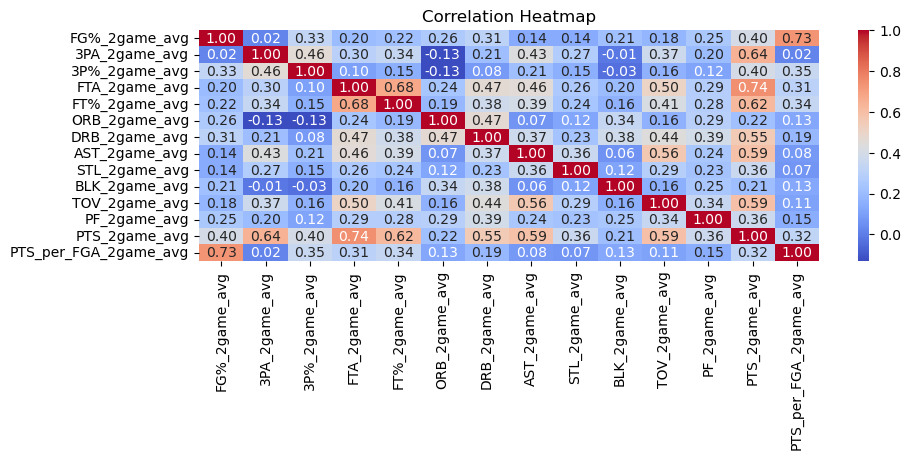

'\nHighly correlated features (> 0.9):\n------------------\nFG, FGA   --> 0.93\nFG, PTS   --> 0.98\nFG, GmSc  --> 0.93\nFGA, PTS  --> 0.93\n3P, 3PA   --> 0.87\nFT, FTA   --> 0.97\nGmSc, PTS --> 0.94\n------------------\ndrop FG, GmSc, 3P, FT\n'

In [11]:
correlation_matrix = X_clustering.corr()

plt.figure(figsize=(10, 3))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

"""
Highly correlated features (> 0.9):
------------------
FG, FGA   --> 0.93
FG, PTS   --> 0.98
FG, GmSc  --> 0.93
FGA, PTS  --> 0.93
3P, 3PA   --> 0.87
FT, FTA   --> 0.97
GmSc, PTS --> 0.94
------------------
drop FG, GmSc, 3P, FT
"""

# K-Means Clustering

## Find Optimal K Clusters
- We will first perform standardization on the data because some features have higher magnitudes of range in values compared to others.
- Determine the number of clusters to use in K-Means by calculating the silhoutte score
- Use K-Means

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)

In [ ]:
# elbow method suggests between 3-7 clusters
inertia = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 20), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


In [ ]:
range_n_clusters = list(range(3, 10)) 

silhouette_scores = []

for n_clusters in range_n_clusters:
  kmeans = KMeans(n_clusters=n_clusters, random_state=42)
  cluster_labels = kmeans.fit_predict(X_scaled)

  silhouette_avg = silhouette_score(X_scaled, cluster_labels)
  silhouette_scores.append(silhouette_avg)

  print(f"For n_clusters = {n_clusters}, the average silhouette score is: {silhouette_avg}")

plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xticks(range_n_clusters)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different Numbers of Clusters")
plt.show()


## Run K-Means Clustering

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
X_clustering['cluster'] = clusters

## Evaluate KMeans

In [ ]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
cluster_centers = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, alpha=0.5, s=5, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=100, marker='X')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Clusters')
plt.show()

In [ ]:
tsne = cumlTSNE(n_components=2, random_state=42, perplexity=5) 
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap='viridis', alpha=0.4, s=5)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of Clusters')
plt.show()


K-Means performed a decent job with defining the 4 clusters and centroids but there is still overlap between each, as some are more elongated than others. We will compare K-Means and Spectral Clustering's graph theory-based methods.

# Spectral Clustering

## Prepare dataset and generate a sparse similarity matrix for better effeciency with a similarity score threshold.

## Create Edge Lists with chunks to preserve memory usage

In [25]:
X_clustering_cp = cp.array(X_clustering)

### Create Edge Lists in chunks

In [26]:
def chunked_edge_list_creation(X, chunk_size, threshold=0.5, metric='cosine', output_file_prefix='edge_list_chunk_', write_chunk_size=100_000):
    n_samples = X.shape[0]
    
    # Initialize edge list and counters
    edge_list = cudf.DataFrame(columns=['src', 'dst', 'weight'], dtype='float32')
    chunk_counter = 0

    for i in range(0, n_samples, chunk_size):
        end_i = min(i + chunk_size, n_samples)
        for j in range(0, n_samples, chunk_size):
            end_j = min(j + chunk_size, n_samples)

            chunk = pairwise_distances(X[i:end_i], X[j:end_j], metric=metric)
            similarity_chunk = 1 - chunk  # Cosine similarity = 1 - cosine distance
            
            # Apply threshold to sparsify the matrix
            mask = similarity_chunk > threshold
            src = cp.nonzero(mask)[0] + i
            dst = cp.nonzero(mask)[1] + j
            weights = similarity_chunk[mask]
            
            # Convert to CuDF DataFrame and append to edge_list
            chunk_edge_list = cudf.DataFrame({
                'src': src.astype('int32'),
                'dst': dst.astype('int32'),
                'weight': weights
            })
            edge_list = cudf.concat([edge_list, chunk_edge_list], ignore_index=True)
            
            # Periodically write to a new Parquet file and clear memory
            if len(edge_list) >= write_chunk_size:
                chunk_file_name = f"{output_file_prefix}{chunk_counter}.parquet"
                edge_list.to_parquet(chunk_file_name)
                chunk_counter += 1
                edge_list = cudf.DataFrame(columns=['src', 'dst', 'weight'], dtype='float32')
                cp.get_default_memory_pool().free_all_blocks()
                cp.cuda.Device().synchronize()

            # Free memory by deleting the chunk and releasing GPU memory
            del chunk, similarity_chunk, mask, src, dst, weights, chunk_edge_list
            cp.get_default_memory_pool().free_all_blocks()
            cp.cuda.Device().synchronize()

            if j % 5 == 0:
                cp.get_default_memory_pool().free_all_blocks()
        
    # Write any remaining data
    if len(edge_list) > 0:
        chunk_file_name = f"{output_file_prefix}{chunk_counter}.parquet"
        edge_list.to_parquet(chunk_file_name)
    
    return edge_list


In [27]:
chunk_size = 5000
threshold = 0.85
data_dir = os.path.join('data')
output_file_prefix = os.path.join(data_dir, 'edge_list_chunk')
edge_list = chunked_edge_list_creation(X_clustering_cp, chunk_size=chunk_size, threshold=threshold, output_file_prefix=output_file_prefix)

### Save edge list chunks to a full edge list file

In [11]:
# Function to process and save batches to a temporary Parquet file
def process_and_save_batch(chunk_files, output_file, batch_size=10):
    # Temporary file to accumulate the results
    batch_file = output_file.replace('.parquet', '_batch.parquet')

    for i in range(0, len(chunk_files), batch_size):
        # Process a batch of files
        batch = cudf.DataFrame(columns=['src', 'dst', 'weight'], dtype='float32')
        for f in chunk_files[i:i+batch_size]:
            chunk = cudf.read_parquet(f)
            chunk = chunk[chunk['src'] != chunk['dst']]  # Remove self-loops
            batch = cudf.concat([batch, chunk], ignore_index=True)
        
        # Write the batch to disk
        if os.path.exists(batch_file):
            # Concatenate with the existing batch file
            existing_batch = cudf.read_parquet(batch_file)
            batch = cudf.concat([existing_batch, batch], ignore_index=True)
            os.remove(batch_file)  # Remove old file to free up memory
        batch.to_parquet(batch_file)

        # Clear memory using RMM
        del batch
        rmm.reinitialize()  # Reset the RMM pool to free memory

    # Move the final batch file to the output file
    os.rename(batch_file, output_file)

# Directory and final output file
data_dir = os.path.join('data')
final_output_file = os.path.join(data_dir, 'full_edge_list.parquet')

# Check if the full edge list file exists and remove it if it does
if os.path.exists(final_output_file):
    os.remove(final_output_file)

# Get all chunk files
chunk_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith('edge_list_chunk') and f.endswith('.parquet')]

# Process and save in batches
process_and_save_batch(chunk_files, final_output_file, batch_size=10)

# Clean up - delete the original chunk files
for f in chunk_files:
    os.remove(f)


## Run Spectral Clustering

### Set up graph with edge list

In [12]:
data_dir = os.path.join('data')
edge_list_file = os.path.join(data_dir, 'full_edge_list.parquet')

edge_list = cudf.read_parquet(edge_list_file)

edge_list['src'] = edge_list['src'].astype('int32')
edge_list['dst'] = edge_list['dst'].astype('int32')
# edge_list['log_weight'] = cp.log(edge_list['weight'])

# Create a graph from the edge list
G = cugraph.Graph()
G.from_cudf_edgelist(edge_list, source='src', destination='dst', edge_attr='weight')

### Modularity Maximization

In [16]:
num_clusters = 4
num_eigen_vects = 4

# Perform spectral clustering
mm_gdf = cugraph.spectralModularityMaximizationClustering(G, num_clusters, num_eigen_vects=num_eigen_vects)

print(mm_gdf.head())
print(mm_gdf.shape)

   vertex  cluster
0   38129        0
1   48489        0
2   17711        0
3   49712        0
4   38601        0
(55496, 2)


In [18]:
mm_gdf.to_parquet('data/clustering_results.parquet')

## Evaluate

In [12]:
mm_df = pd.read_parquet('data/clustering_results.parquet')

In [13]:
mm_df['cluster'].value_counts()

cluster
3    21263
1    20515
2     9331
0     4387
Name: count, dtype: int64

In [19]:
aligned_X_clustering = X_clustering.loc[mm_df.index]

# Now calculate the silhouette score
silhouette_avg = silhouette_score(aligned_X_clustering, mm_df['cluster'])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: -0.004904756683360547


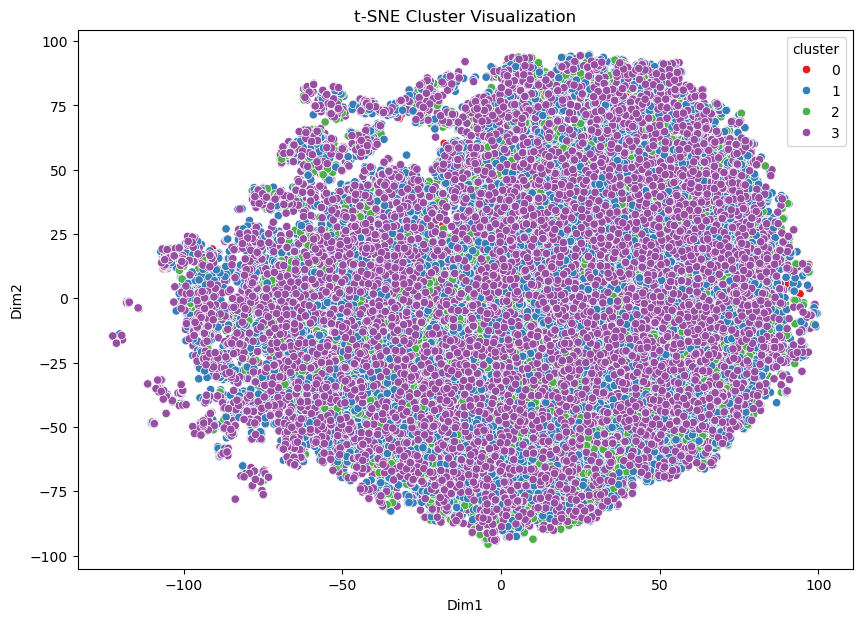

In [22]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(aligned_X_clustering)

tsne_df = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2'])
tsne_df['cluster'] = mm_df['cluster'].values

# Plot the t-SNE results with the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x='Dim1', y='Dim2', hue='cluster', data=tsne_df, palette='Set1')
plt.title('t-SNE Cluster Visualization')
plt.show()


# cuML KMeans Clustering

## Run KMeans

In [33]:
kmeans = cumlKMeans(n_clusters=4, random_state=42)
kmeans.fit